In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import mixture
from multiprocessing import Pool

In [38]:
# load in coverage data at ATAC peaks

coverage_file = 'islet.bams_ATAC.summary.sort.subpeak.tab'
coverage = pd.read_csv(coverage_file, sep='\t', header=0)
coverage['peak'] = coverage['#chrom'].apply(str) + ':' + coverage['start'].apply(str) + '-' + coverage['end'].apply(str)
coverage['peak_length'] = coverage['end'] - coverage['start']
coverage.drop(['#chrom', 'start','end'], axis=1, inplace=True)
coverage.set_index('peak', inplace=True)

In [39]:
# create new dataframe for normalized coverage

coverage_normalized = pd.DataFrame(coverage['peak_length'])
coverage_normalized['subpeak'] = coverage['subpeak']

# first normalize to total read coverage

read_counts_file = 'read_coverage.txt'
read_counts = {line.split('\t')[0]: int(line.split('\t')[1]) for line in open(read_counts_file).read().splitlines()}
for key in read_counts.keys():
    coverage[key] = coverage[key]/read_counts[key]

# next subtract control (input ChIP) from the treatment

match_treatment_controls_file = 'match_treatment_to_controls.txt'
with open(match_treatment_controls_file) as f:
    for line in f.read().splitlines():
        treat = line.split('\t')[0]
        control = line.split('\t')[1]
        coverage_normalized['{}-{}'.format(treat, control)] = coverage[treat] - coverage[control]

# scale the features to 0 mean and unit variance (z-score scaling)

coverage_scaler = preprocessing.RobustScaler()
coverage_scaler.fit(coverage_normalized)
coverage_normalized = pd.DataFrame(coverage_scaler.transform(coverage_normalized), 
                                   index=coverage_normalized.index, 
                                   columns=coverage_normalized.columns)

In [40]:
# Gaussian mixture model
# http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

# Covariance types:
## 'full' (each component has its own general covariance matrix),
## 'tied' (all components share the same general covariance matrix),
## 'diag' (each component has its own diagonal covariance matrix),
## 'spherical' (each component has its own single variance).


def run_mixture(n):
    model = {}
    cov_types = ['full']#, 'tied', 'diag', 'spherical']
    for cov in cov_types:
        model[cov] = mixture.GaussianMixture(n_components=n, 
                                        covariance_type=cov, 
                                        max_iter=100, 
                                        verbose=0).fit(coverage_normalized)
    return model

max_feat = 30
N = np.arange(1, max_feat+1)
with Pool(processes=10) as pool:
    models = pool.map(run_mixture, N)

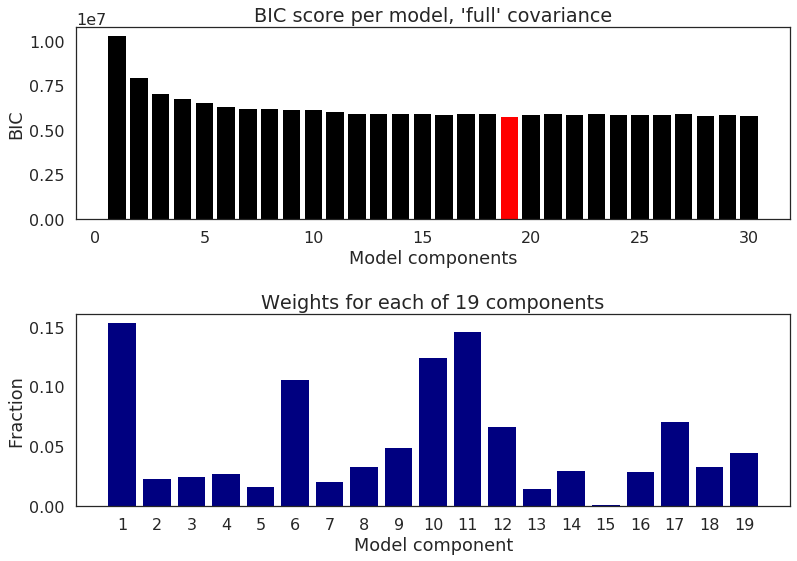

In [41]:
# get methods from the models

bic, weights, means, n_iter, loglk, status = {}, {}, {}, {}, {}, {}
for mod in models:
    for cov in mod.keys():
        bic[cov] = bic.get(cov, []) + [mod[cov].bic(coverage_normalized)]
        weights[cov] = weights.get(cov, []) + [mod[cov].weights_]
        means[cov] = means.get(cov, []) + [mod[cov].means_]
        n_iter[cov] = n_iter.get(cov, []) + [mod[cov].n_iter_]
        loglk[cov] = loglk.get(cov, []) + [mod[cov].lower_bound_]
        status[cov] = status.get(cov, []) + [mod[cov].converged_]

bic_val, n_bic = min((val, idx) for (idx, val) in enumerate(bic['full']))
weights_n_bic = weights['full'][n_bic]

plt.style.use('seaborn-white')
plt.style.use('seaborn-poster')
plt.clf()
fig, (ax1, ax2) = plt.subplots(2,1)
fig.subplots_adjust(hspace=.5)

# plot BIC (Bayesian Information Criterion) against number of components

a1_full = ax1.bar(np.arange(1,max_feat+1), bic['full'], label='full', color='black')
a1_full[n_bic].set_facecolor('red')
#bar_width=0.2
#ax1.bar(np.arange(1+bar_width,max_feat+1+bar_width), bic['tied'], label='tied', width=bar_width)
#ax1.bar(np.arange(1+2*bar_width,max_feat+1+2*bar_width), bic['diag'], label='diag', width=bar_width)
#ax1.bar(np.arange(1+3*bar_width,max_feat+1+3*bar_width), bic['spherical'], label='spherical', width=bar_width)
#ax1.legend(loc='upper right', shadow=True)
ax1.set_title('BIC score per model, \'full\' covariance')
ax1.set_xlabel('Model components')
ax1.set_ylabel('BIC')

# plot weights of the components for the model with the lowest BIC

ax2.bar(np.arange(1, len(weights_n_bic) + 1), weights_n_bic, color='navy')
ax2.set_xticks(np.arange(1, len(weights_n_bic) + 1))
ax2.set_title('Weights for each of {} components'.format(n_bic+1))
ax2.set_xlabel('Model component')
ax2.set_ylabel('Fraction')
plt.show()

In [42]:
# get the means for model with the lowest bic score
clusters = pd.DataFrame(means['full'][n_bic], columns=coverage_normalized.columns, index=np.arange(1,n_bic+2))
clusters

,peak_length,subpeak,CTCF.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR2.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR3.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR1.Male.Stitzel-Input.BR3.Male.Stitzel,H3K27ac.BR1.Male.Parker-Input.BR1.Male.Parker,H3K27ac.BR2.Female.Parker-Input.BR3.Female.Parker,H3K27ac.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,H3K27ac.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,...,FOXA2.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,FOXA2.BR2.Male.Pasquali-Input.BR1.Male.Pasquali,MAFB.BR1.Female.Pasquali-Input.BR1.Male.Pasquali,MAFB.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,NKX2_2.BR1.Female.Pasquali-Input.BR1.Male.Pasquali,NKX2_2.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,NKX6_1.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,NKX6_1.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,PDX1.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,PDX1.BR2.Male.Pasquali-Input.BR1.Male.Pasquali
1,-0.231985,0.000000,-0.180723,-0.164899,-0.206058,-0.235587,-0.027228,-0.224118,-0.188668,-0.067965,...,-0.231759,-0.204628,-0.236574,-0.222776,-0.362363,-0.361625,-0.335520,-0.382062,-0.276322,-0.328755
2,0.813032,0.462303,-0.103460,0.113119,0.063521,0.119897,1.674425,1.546381,1.532681,1.597941,...,1.440114,1.532734,1.573948,1.206090,1.003715,1.036725,0.777469,0.733745,0.913086,0.834874
3,0.250289,0.173288,6.776450,7.886094,7.677672,4.897710,0.209787,0.143395,0.179331,0.266177,...,0.967688,1.088906,1.346692,0.982199,0.597060,0.731806,0.513099,0.322376,0.588864,0.681116
4,1.413608,0.932278,0.675048,1.142214,0.827605,0.559517,2.101323,0.738124,0.850958,1.055193,...,-0.138641,-0.128368,-0.058984,-0.176351,0.101963,-0.079682,-0.193850,0.221507,-0.147616,-0.093471
5,2.233989,1.226635,3.386148,4.538942,4.083625,3.056611,5.422150,3.363063,3.505462,4.291971,...,2.163778,2.569362,2.297030,1.821963,1.817397,1.617668,1.141102,1.675347,1.652037,1.640580
6,-0.227377,0.000000,6.468404,7.401317,7.159513,4.523537,-0.039045,-0.278504,-0.247902,-0.122405,...,-0.025681,-0.020576,-0.000587,-0.064565,-0.073729,-0.001664,-0.029947,-0.120268,-0.043869,-0.026808
7,0.734856,0.686902,-0.266878,-0.165233,-0.212183,-0.167098,0.177333,0.215163,0.232164,0.263498,...,0.475933,0.410762,0.220576,0.004241,0.092659,0.103158,0.145093,-0.077359,0.214339,0.150634
8,0.531113,0.277814,-0.219687,-0.059523,-0.092558,0.228270,-0.032968,0.551421,0.706433,0.232968,...,4.605006,5.622593,3.677144,3.213592,2.137614,2.614946,3.042944,2.091323,3.785657,3.685152
9,2.124399,1.178930,0.152776,0.488931,0.418185,0.284417,5.815072,3.083776,3.149473,3.914557,...,0.408649,0.426615,0.583846,0.325295,1.190703,0.866823,0.517603,1.158334,0.604147,0.684358
10,0.174651,0.000000,-0.170822,-0.025173,-0.075900,-0.009351,0.398633,0.476944,0.546638,0.587106,...,1.054680,1.055213,1.037978,0.752496,0.678122,0.737052,0.533377,0.381458,0.618881,0.586553


/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


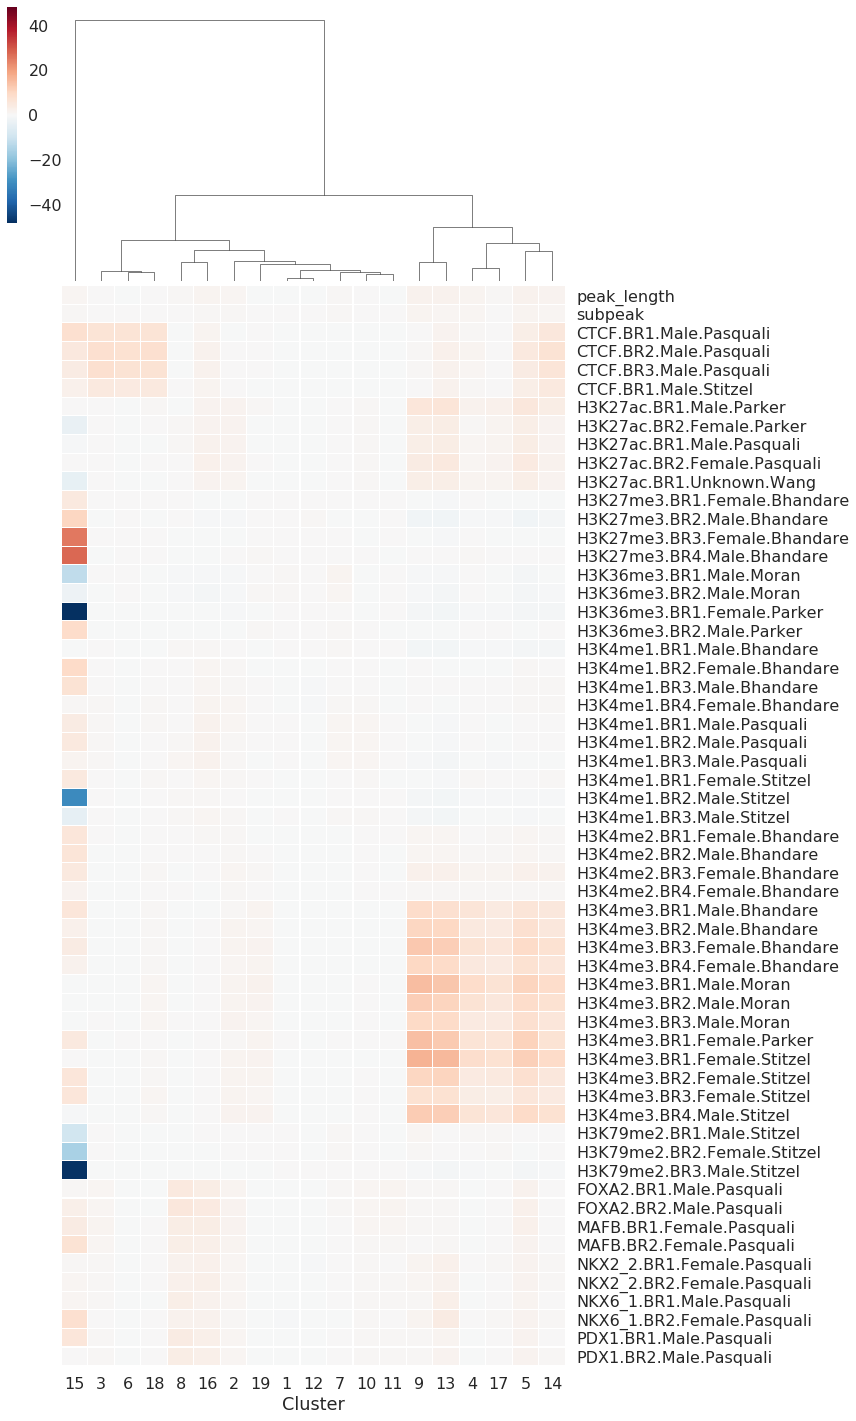

In [63]:
plt.clf()
# before getting rid of high signal cluster
clusters_transpose = data=clusters.transpose()
g = sns.clustermap(clusters_transpose, 
                   row_cluster=False, 
                   linewidths=0.1, 
                   figsize=(10,25),
                   yticklabels=[label.split('-')[0] for label in clusters_transpose.index.values])
g.ax_heatmap.set_xlabel('Cluster')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()
#models[n_bic]['full'].predict_proba(coverage_normalized)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


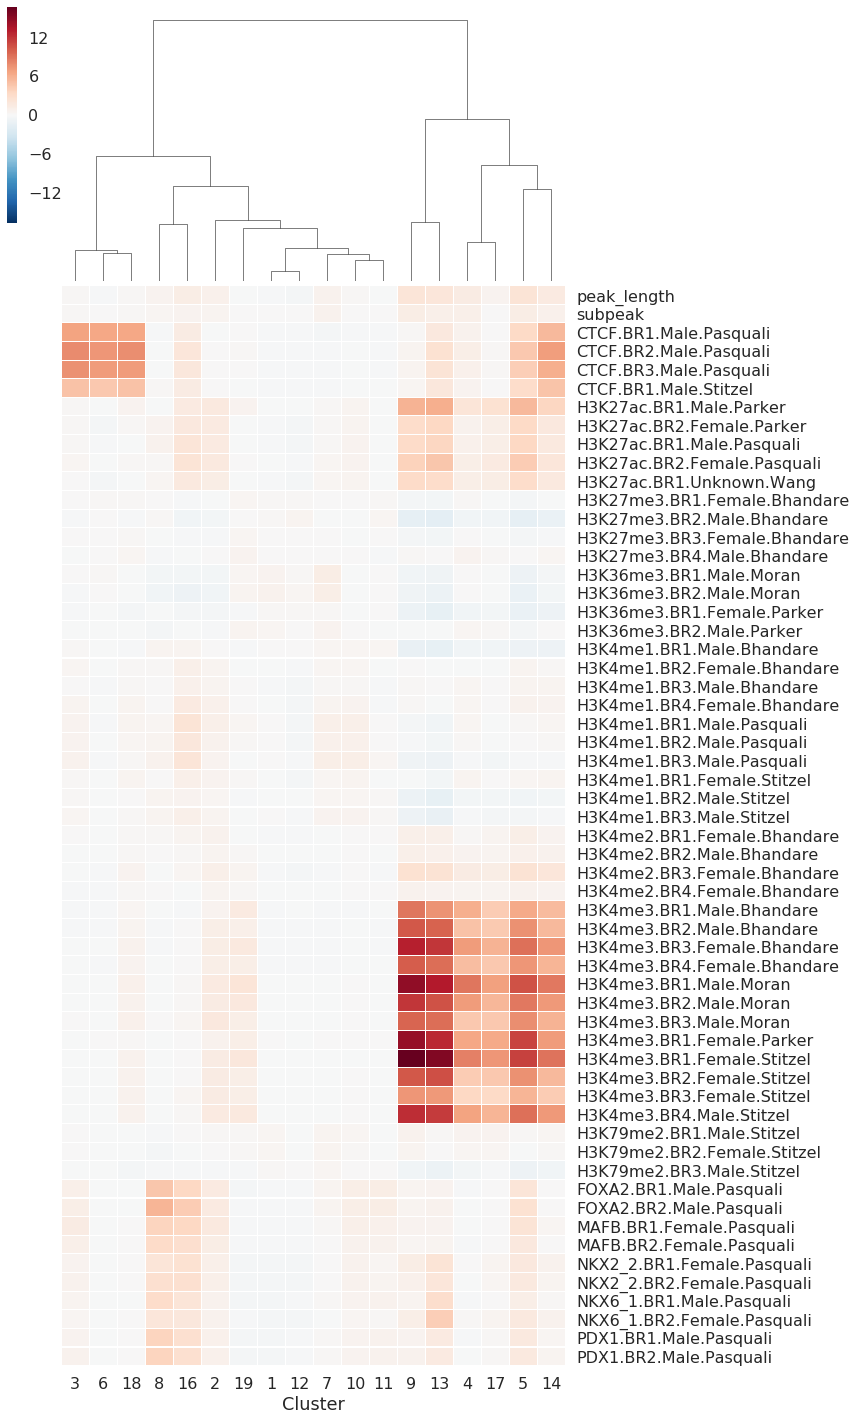

In [68]:
plt.clf()
drop_cluster = 15
clusters_transpose_dropped = clusters.transpose().drop([drop_cluster], axis=1)

# drop high signal cluster

g2 = sns.clustermap(data=clusters_transpose_dropped,
                    row_cluster=False, 
                    linewidths=0.1, 
                    figsize=(10,25),
#                    standard_scale=0,
                    yticklabels=[label.split('-')[0] for label in clusters_transpose_dropped.index.values])
g2.ax_heatmap.set_xlabel('Cluster')
plt.setp(g2.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [30]:
clusters_transformed = pd.DataFrame(coverage_scaler.inverse_transform(means['full'][n_bic]), 
             columns=coverage_normalized.columns, index=np.arange(1,n_bic+2))
clusters_transformed

,peak_length,subpeak,CTCF.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR2.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR3.Male.Pasquali-Input.BR1.Male.Pasquali,CTCF.BR1.Male.Stitzel-Input.BR3.Male.Stitzel,H3K27ac.BR1.Male.Parker-Input.BR1.Male.Parker,H3K27ac.BR2.Female.Parker-Input.BR3.Female.Parker,H3K27ac.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,H3K27ac.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,...,FOXA2.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,FOXA2.BR2.Male.Pasquali-Input.BR1.Male.Pasquali,MAFB.BR1.Female.Pasquali-Input.BR1.Male.Pasquali,MAFB.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,NKX2_2.BR1.Female.Pasquali-Input.BR1.Male.Pasquali,NKX2_2.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,NKX6_1.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,NKX6_1.BR2.Female.Pasquali-Input.BR1.Male.Pasquali,PDX1.BR1.Male.Pasquali-Input.BR1.Male.Pasquali,PDX1.BR2.Male.Pasquali-Input.BR1.Male.Pasquali
1,319.442650,1.000000,-6.668624e-08,-5.483879e-08,-5.235081e-08,1.152989e-08,6.168521e-07,5.910387e-07,5.677166e-07,7.089676e-07,...,2.759412e-07,1.244565e-07,2.040486e-07,-1.588507e-08,5.672895e-07,3.759745e-07,1.425363e-07,2.229407e-08,1.034334e-07,1.218419e-07
2,990.909836,2.204242,8.986723e-08,5.947446e-07,3.277575e-07,4.897709e-07,2.127083e-05,6.153439e-06,8.403799e-06,1.298090e-05,...,1.338477e-06,1.056280e-06,9.067251e-07,1.086291e-07,3.539106e-06,2.066934e-06,6.760658e-07,6.743251e-07,7.516494e-07,8.437655e-07
3,431.217408,1.194605,2.834427e-06,7.261925e-06,4.622045e-06,4.664914e-06,1.236446e-06,1.053000e-06,1.218651e-06,1.501222e-06,...,1.607862e-06,1.304609e-06,1.891158e-06,4.108551e-07,2.545611e-06,2.094655e-06,8.018693e-07,3.531983e-07,8.531136e-07,9.418035e-07
4,510.125943,1.299253,-2.288935e-08,1.552188e-07,7.722449e-08,2.291636e-07,6.253963e-06,3.104865e-06,3.839562e-06,5.084880e-06,...,1.398336e-06,1.074115e-06,1.633529e-06,3.672655e-07,2.740265e-06,1.994802e-06,7.620972e-07,4.577642e-07,8.712186e-07,8.070228e-07
5,995.167731,2.200546,1.616943e-06,4.787136e-06,2.823525e-06,3.519163e-06,2.247175e-05,7.707909e-06,1.087076e-05,1.719574e-05,...,3.118592e-06,2.860966e-06,3.164152e-06,8.088910e-07,6.877375e-06,4.760686e-06,2.278983e-06,1.755910e-06,2.333415e-06,2.173105e-06
6,288.792420,1.000000,2.616452e-06,6.606688e-06,4.175807e-06,4.184167e-06,1.939455e-07,2.133468e-07,7.109154e-08,9.236410e-08,...,4.353184e-07,2.528553e-07,3.844018e-07,3.725178e-08,1.001771e-06,8.458006e-07,3.615796e-07,1.326791e-07,2.901003e-07,3.561323e-07
7,593.518811,1.726493,-8.918046e-08,-1.500323e-08,-2.929860e-08,1.330231e-07,2.603283e-06,1.681979e-06,2.095986e-06,2.598020e-06,...,1.262940e-06,8.631379e-07,7.913809e-07,9.149861e-08,1.837727e-06,1.323656e-06,5.852465e-07,2.300740e-07,6.301796e-07,5.985852e-07
8,510.005291,1.339461,-7.605775e-08,2.091016e-09,-2.504532e-09,3.925474e-07,1.105137e-07,1.648392e-06,2.386774e-06,9.817257e-07,...,6.691313e-06,6.499656e-06,4.721062e-06,1.314689e-06,6.369827e-06,5.689540e-06,3.280859e-06,1.373094e-06,4.436609e-06,4.022267e-06
9,669.534928,1.513548,5.048330e-08,3.071491e-07,1.640842e-07,2.767598e-07,1.204603e-05,3.211940e-06,4.625428e-06,6.967711e-06,...,3.937365e-07,2.343262e-07,4.534783e-07,4.526816e-08,2.106648e-06,1.138075e-06,3.795780e-07,4.626912e-07,3.806496e-07,4.768778e-07
10,416.321142,1.000000,-5.041260e-08,9.062733e-08,4.110938e-08,2.589867e-07,1.755192e-06,1.815533e-06,2.475065e-06,2.801395e-06,...,2.370901e-06,1.886514e-06,2.259963e-06,5.280005e-07,3.449849e-06,2.717942e-06,1.102127e-06,5.122136e-07,1.288375e-06,1.220123e-06


In [ ]:
def run_bayesian_mixture(weight_conc_prior):
    bgmm_model = mixture.BayesianGaussianMixture(n_components=20,
                                                 covariance_type='full',
                                                 weight_concentration_prior=weight_conc_prior,
                                                 weight_concentration_prior_type='dirichlet_process',
                                                 max_iter=1000,
                                                 verbose=2,
                                                 verbose_interval=10)
    bgmm_model.fit(coverage_normalized)
    print('Finishing up model with weight concentration prior {}'.format(weight_conc_prior))
    return bgmm_model

weight_concs = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
with Pool(processes=len(weight_concs)) as pool:
    bgmm_models = pool.map(run_bayesian_mixture, weight_concs)

Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
Initialization 0
  Iteration 0	 time lapse 22.98579s	 ll change inf
  Iteration 0	 time lapse 23.68726s	 ll change inf
  Iteration 0	 time lapse 24.31142s	 ll change inf
  Iteration 0	 time lapse 24.34151s	 ll change inf
  Iteration 0	 time lapse 24.87893s	 ll change inf
  Iteration 0	 time lapse 24.95916s	 ll change inf
  Iteration 10	 time lapse 113.82683s	 ll change 16420.92864
  Iteration 10	 time lapse 114.99655s	 ll change 16420.79896
  Iteration 10	 time lapse 115.77921s	 ll change 16422.07209
  Iteration 10	 time lapse 116.55785s	 ll change 16430.52851
  Iteration 10	 time lapse 118.70334s	 ll change 16450.53326
  Iteration 10	 time lapse 116.92813s	 ll change 16420.81078
  Iteration 20	 time lapse 98.30482s	 ll change 766.92602
  Iteration 20	 time lapse 115.47469s	 ll change 766.88637
  Iteration 20	 time lapse 116.25985s	 ll change 766.91480
  Iteration 20	 time lapse 114.62367s	 ll change 7